In [1]:
import numpy as np
import pandas as pd
import scipy.stats

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('../data/combinedData.csv')
target = pd.read_csv('../data/combinedTarget.csv')

data = data.merge(target, how='left',on=['Provider','Set'])
data.drop(columns = ['Unnamed: 0_x','Unnamed: 0_y'], inplace=True)

/usr/local/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (10,13,14,24) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Warmup Question 3, Time Series Analysis:
- Based on the attribute **ClaimStartDt**, analyze the weekly service volume variations.

In [2]:
from datetime import datetime

In [15]:
data['ClaimStartDt'] = pd.to_datetime(data['ClaimStartDt'] , format = '%Y-%m-%d')
data['ClaimEndDt'] = pd.to_datetime(data['ClaimEndDt'] , format = '%Y-%m-%d')

In [16]:
data['ClaimStMonth'] = data['ClaimStartDt'].dt.month
data['ClaimEndMonth'] = data['ClaimEndDt'].dt.month

In [5]:
data['ClaimDayName'] = data['ClaimStartDt'].dt.day_name()

In [6]:
data['ClaimStartWeek'] = data['ClaimStartDt'].dt.week

In [7]:
weeklyVol = data.groupby(['ClaimStartWeek','Status'])['ClaimID'].count().reset_index()

In [8]:
data.State

0         Pennsylvania
1         Pennsylvania
2         Pennsylvania
3              Alabama
4              Alabama
              ...     
693598            Ohio
693599            Ohio
693600            Ohio
693601    Pennsylvania
693602            Iowa
Name: State, Length: 693603, dtype: object

In [9]:
weeklyVol

,ClaimStartWeek,Status,ClaimID
0,1,in,994
1,1,out,8000
2,2,in,1020
3,2,out,12659
4,3,in,999
...,...,...,...
101,51,out,10889
102,52,in,965
103,52,out,10762
104,53,in,99


In [10]:
weeklyVol['logVol'] = np.log(weeklyVol.ClaimID)

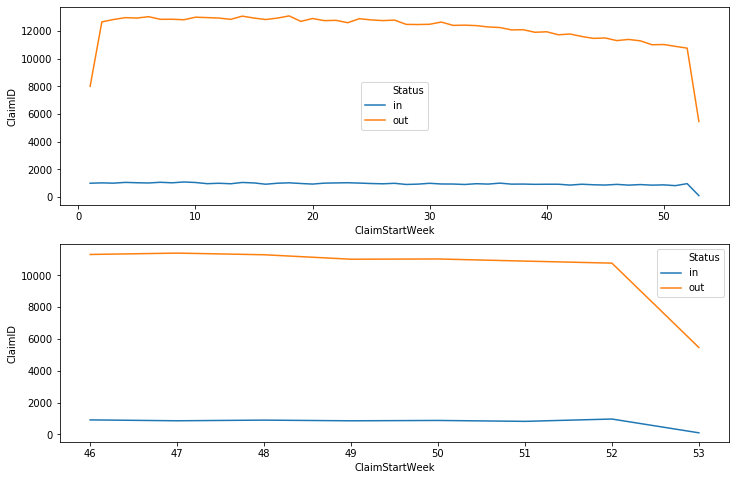

In [11]:
plt.figure(figsize=(12,8))


ax1 = plt.subplot(211)
sns.lineplot(x = 'ClaimStartWeek', y = 'ClaimID', hue = 'Status', data = weeklyVol)



ax1 = plt.subplot(212)
sns.lineplot(x = 'ClaimStartWeek', y = 'ClaimID', hue = 'Status', data = weeklyVol[weeklyVol.ClaimStartWeek > 45])

- What are the weekly patterns (weekly seasonalities) you observe for the demands on **inpatient** or **outpatient**
services?

Sharp drop around Christmas

- Identify the top $5$ most frequent **ClmAdmitDiagnosisCodes** and trace their weekly seasonalities.
Display the patterns you find.

In [2]:
diagCodes = data[['ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
       'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6',
       'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9',
       'ClmDiagnosisCode_10', 'ClaimID']]

In [3]:
diagMelt = diagCodes.melt(id_vars = 'ClaimID').dropna(axis=0)

In [9]:
diagCounts = diagCodes.melt(id_vars = 'ClaimID').dropna(axis=0)['value'].value_counts().sort_values(ascending=False).reset_index()

In [13]:
diagCounts.columns = ['DiagCode','Count']
diagCounts.to_csv('../diagCounts.csv')

In [12]:
top5 = diagCounts.head(10).index.values
diagCounts[:10]

4019     95437
25000    46471
2724     44302
V5869    31013
4011     29420
42731    24996
V5861    24812
2720     22605
2449     21693
4280     19277
Name: value, dtype: int64

In [119]:
diagTop5 = data[['ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
       'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6',
       'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9',
       'ClmDiagnosisCode_10', 'ClaimID','ClaimStartWeek']]

In [121]:
diagMelt = diagTop5.melt(id_vars = ['ClaimID','ClaimStartWeek'], var_name = '#', value_name = 'DiagCode').dropna(axis=0)

In [130]:
diag5 = diagMelt[diagMelt.DiagCode.isin(top5)].groupby(['DiagCode','ClaimStartWeek'])['ClaimID'].count().reset_index()

In [134]:
diag5['logVol'] = np.log(diag5.ClaimID)

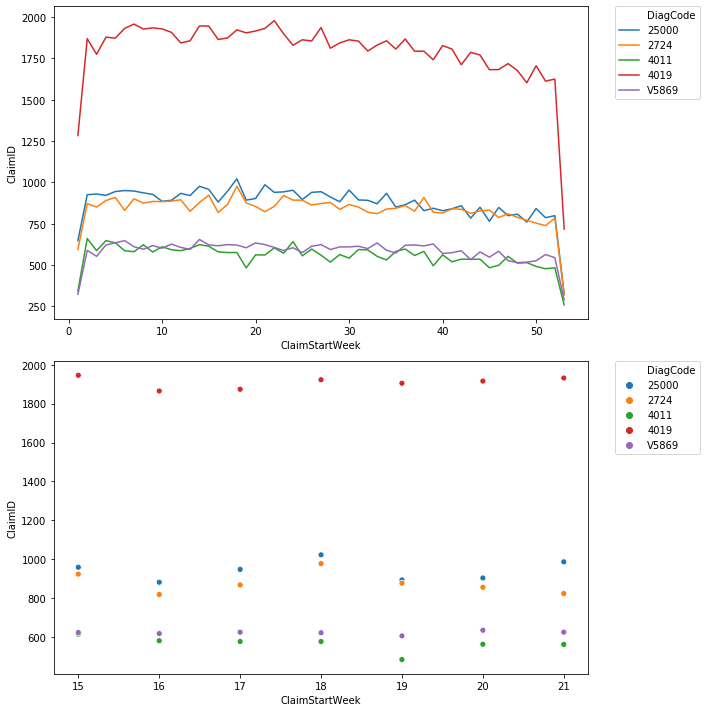

In [145]:
plt.figure(figsize=(10,10))


ax1 = plt.subplot(211)
ax1 = sns.lineplot(x = 'ClaimStartWeek', y = 'ClaimID', hue = 'DiagCode', data = diag5)
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


ax2 = plt.subplot(212)
ax2 = sns.scatterplot(x = 'ClaimStartWeek', y = 'ClaimID', 
                   hue = 'DiagCode', 
                   data = diag5[diag5.ClaimStartWeek.isin(range(15,22,1))])
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

- For the inpatient patients, is there any pattern between the durations of the treatments and
the patient attributes?


Race, Age, Gender, NumChronics

In [146]:
inpat = data[data.Status=='in']
inpat.head()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,...,WhetherDead,NumChronics,NumProc,NumDiag,AdmissionDays,ClaimDays,Age,PotentialFraud,ClaimStartWeek,ClaimDayName
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,...,0,7,0,10,7.0,7,66.0,Yes,15,Sunday
1,BENE11001,CLM66048,2009-08-31,2009-09-02,PRV55907,5000,PHY318495,PHY318495,NaN,2009-08-31,...,0,7,1,4,3.0,3,67.0,No,36,Monday
2,BENE11001,CLM68358,2009-09-17,2009-09-20,PRV56046,5000,PHY372395,NaN,PHY324689,2009-09-17,...,0,7,0,7,4.0,4,67.0,No,38,Thursday
3,BENE11011,CLM38412,2009-02-14,2009-02-22,PRV52405,5000,PHY369659,PHY392961,PHY349768,2009-02-14,...,0,6,1,10,9.0,9,95.0,No,7,Saturday
7,BENE11014,CLM63689,2009-08-13,2009-08-30,PRV56614,10000,PHY379376,PHY398258,NaN,2009-08-13,...,0,5,1,10,18.0,18,71.0,No,33,Thursday


In [159]:
meanDays = inpat.groupby(['Age','Gender'])['AdmissionDays','ClaimDays'].mean().reset_index()

sns.lineplot(x = 'Age',y = 'AdmissionDays', hue = 'Gender', data = meanDays)

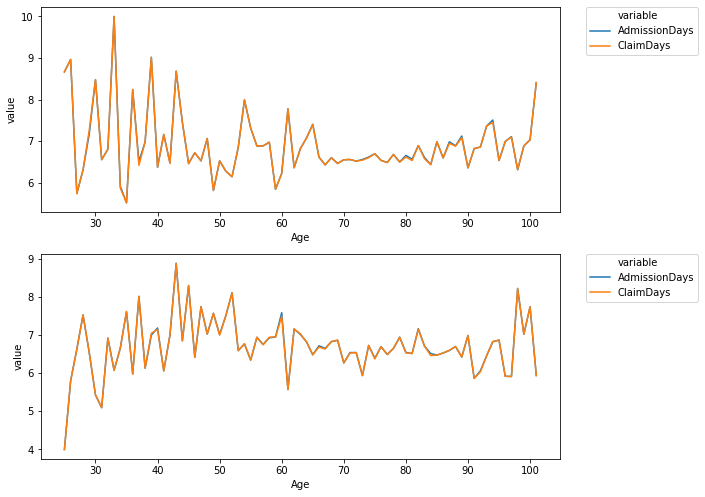

In [340]:

meanDays = inpat.groupby(['Age','Gender'])['AdmissionDays','ClaimDays'].mean().reset_index()


d = meanDays.melt(id_vars = ['Age','Gender'])
plt.figure(figsize=(10,10))


ax1 = plt.subplot(311)
ax1 = sns.lineplot(x = 'Age',y = 'value', hue = 'variable',data = d[d.Gender == 0])
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

ax1 = plt.subplot(312)
ax1 = sns.lineplot(x = 'Age',y = 'value', hue = 'variable',data = d[d.Gender == 1])
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


- For the monthly inpatient/outpatient claim counts of all the providers, please analyze the
table of provider-month matrices and report any interesting findings.

- **hint**: dataframe's pivot_table method could be used to construct the provider-month matrix.

In [34]:
in_month = data[data.Status=='in'].groupby(['ClaimStMonth','Provider'])['ClaimID'].count().reset_index().pivot(index='Provider', columns ='ClaimStMonth',values='ClaimID').fillna(0)
out_month = data[data.Status=='out'].groupby(['ClaimStMonth','Provider'])['ClaimID'].count().reset_index().pivot(index='Provider', columns ='ClaimStMonth',values='ClaimID').fillna(0)

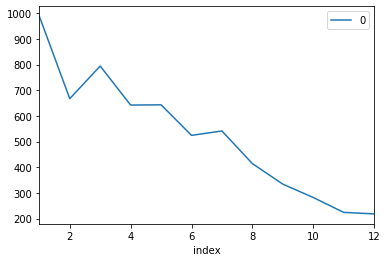

In [51]:
out_month.idxmax(axis=1).value_counts().reset_index().sort_values('index').plot(x = 'index', y = 0)

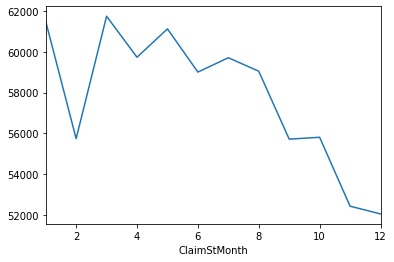

In [49]:
data.groupby('ClaimStMonth')['ClaimID'].count().plot()